<h1> Resolvable Distribution Plotter</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH) and a fiducial model population, plot the distribution of resolvable sources of the PBH compared to the fiducial model.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
import scipy.stats as scst
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad, simpson
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from pycbc import waveform as wf
from multiprocessing import Pool, Manager, Process, Value, Array
from functools import partial
#from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

# Flag needed to simulate the standard LIGO SOBBH population

SOBBH = False
SOBBH_Redevol = False
SOBBH_RSpike = False

# Flags for different types of PBH mass distribution

PBH = False
PBH_fRz = False
PBH_fRt = False
PBH_LogNormal = False
PBH_Gaussian = False

# Flags for fast execution

Compute_SNRMat = False

# Merger distribution parameters

T_obs = 1. # Lisa or LIGO estimated years of observation
efficiency = 1. # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5 # Hertz
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results
# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
MPc = 3.08567758149137*1e22 # meters
GPc = MPc*1e3 # meters
h = 0.678
H_0 = 67.8*1e3/MPc # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 12
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1


<h2> FLAG selection section </h2>

To begin, we have to decide which types of sources we wish to simulate in our SGWB, in order to use the standard _LIGO-Virgo_ fiducial mass function we have to set the _SOBBH_ flag on :

In [3]:
#SOBBH = True # If true, add the total SGWB strain produced by stellar origin binary black hole merging on the strain as estimated by LIGO

if we wish to simulate PBH perturbations, instead, we have to choose between the two following different mass functions :

In [4]:
PBH = True # If true, the FOM will be generated considering a PBH perturbation to the fiducial model

In [5]:
#PBH_LogNormal = True# This will simulate the Log Normal mass distribution for PBH described in ariv 2109.05836
PBH_Gaussian = True # This will simulate a Gaussian PBH mass distribution, that can be used to generalize a bit the standard monocromatic mass function for PBH

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [6]:
SOBBH_Redevol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume

In the case of PBH, instead, we are gonna generate the merging rate following a simple power law with $k = 1.4$ as in [V. Atal et al](https://arxiv.org/abs/2201.12218), for what concern the value of $R_0$, we will consider it to be a certain fraction $f$ of the original _SOBBH_ merging rate. This mode can be run by activating the flag _PBH_fRz_:

In [7]:
#PBH_fRz = True # If true, the merging rate would assumed to be the simple power law evolution of a fixed k, where the value of R0 would be given as a fraction f of the SOBBH one

alternatively, we can describe the evolution with redshift of the merging rate using the model by [S. S. Bavera et al](https://arxiv.org/pdf/2109.05836.pdf), this would describe its evolution as a power law of the _Hubble Time_ at redshift $z$:

In [8]:
PBH_fRt = True # If true, the merging rate would assumed to be a powerlaw of the Hubble time at redshift z, where the value of R0 would be given as a fraction f of the SOBBH one 

The analytical SNR approximation can run using the following two modes for the inclination approximation:

In [9]:
Inc_mode = 'max_i'  # Maximize the estimated SNR by assuming perfect inclination in respect to the detector
#Inc_mode = 'avg_i' # Average the estimated SNR by integrating over all the possible inclinations in respect to the detector

Given the sources, we can furthermore decide if we wish to plot their merging rates in function of $z$ :

In [10]:
#Plot_Rz = True # If true, generate plots at the end of the simulation

we can also decide if recomputing the SNR matrix in the phase space or just use the one we already have as a file:

In [11]:
#Compute_SNRMat = True

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [12]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_max = 1.e8
z_prec = 10000

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        span_z = np.linspace(0.,z,z_prec)
        span_mz = 0.5*(span_z[1::] + span_z[:-1:])
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        Int_Z = c*(10**(-3))*simpson(1./(H(span_mz)*(MPc/1.e3)), span_mz, axis=0)
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    span_z = np.logspace(np.log10(z),np.log10(z_max),z_prec)
    span_mz = 0.5*(span_z[1::] + span_z[:-1:])
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    
    Int_Z = simpson(1./(H(span_mz)*(1. + span_mz)), span_mz, axis=0)
    
    return Int_Z
    
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [13]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = dist_func(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = dist_func(z_2) - dist_func(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [14]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

together with the effective spin :

In [15]:
#Function that given the spin and spin tilt gives the effective spin

def EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2):
    res = (m1*a1*cos(st_a1))/(m1 + m2) + (m2*a2*cos(st_a1))/(m1 + m2) # Hope so, better to double check

<h2> SOBBH LIGO All Channels SGWB </h2>

In this section, we are going to initialize all the objects needed to compute the Stellar Origin Binary Black Hole merging(SOBBHm) SGWB.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).

<h3> SOBBH - Mass distribution functions </h3>

Let's start by defining the probability distribution in function of the masses.

We have :

In [16]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

    
# Mass Distribution parameters (values taken from the results of arxiv 2111.03634)

SOBBH_m = 5.0 # + 0.86 - 1.7  minimum mass allowed by the popolation inference 
SOBBH_M = 100. # Solar Masses, taken from the prior of the paper as no real higher mass cutoff was estimated !
SOBBH_massprec = 500 # Binning density for the masses
SOBBH_alpha = 3.5 # + 0.6 - 0.56 Power law index
SOBBH_betaq = 1.1 # + 1.7 - 1.3  index for m2 power law in q
SOBBH_deltam = 4.9 #+ 3.4 - 3.2  used for the low mass smoothing function, generate peak at delta_m + m_min
SOBBH_lambdapeak = 0.038 # + 0.058 - 0.026 Intensity of the gaussian peak
SOBBH_mum = 34.0 # + 2.6 - 4.0 Location of the Gaussian peak in Solar Masses
SOBBH_sigmam = 5.69 # +4.28 - 4.34 Solar Masses, taken from arxiv 2010.14533 as no additional claim was made on last paper

# Defining of the smoothing function for m close to the minimimum mass

def SOBBH_MassSmoothing(m, SOBBH_m, SOBBH_deltam):
    if(m < SOBBH_m):
        return 0.
    else:
        if(m >= (SOBBH_m + SOBBH_deltam)):
            return 1.
        else:
            factor = np.exp((SOBBH_deltam/(m - SOBBH_m)) + (SOBBH_deltam/(m - SOBBH_m - SOBBH_deltam)))
            return 1./(factor + 1.)

# Defining a normalized power law distribution function, needed for the final distribution function        

def SOBBH_MassPowLaw(m, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm):
    if(SOBBH_m <= m <= SOBBH_M):
        return (1./SOBBH_PLnorm)*(m**(-SOBBH_alpha))
    else:
        return 0.

# Estimating the Phase space of the Power law distribution using trapezoidal integration

def SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha):
    
    mid_m = 0.5*(SOBBH_ranm1[1::] + SOBBH_ranm1[:-1:])
    
    
    if min(mid_m) < SOBBH_m:
        good_idx = mid_m >= SOBBH_m
        mid_m = mid_m[good_idx]
    
    if max(mid_m) > SOBBH_M:
        good_idx = mid_m <= SOBBH_M
        mid_m = mid_m[good_idx]
        
    ris = simpson(np.power(mid_m, (-SOBBH_alpha)), mid_m)

    return ris


# Defining a Gaussian distribution of the mass, needed for the final distribution function

def SOBBH_MassGauss(m, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm):
    if (SOBBH_m <= m <= SOBBH_M):
        return ((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-SOBBH_mum)/SOBBH_sigmam)**2.))*1./SOBBH_GSnorm
    else:
        return 0.
    
def SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam):

    mid_m = 0.5*(SOBBH_ranm1[1::] + SOBBH_ranm1[:-1:])
    
    
    if min(mid_m) < SOBBH_m:
        good_idx = mid_m >= SOBBH_m
        mid_m = mid_m[good_idx]
    
    if max(mid_m) > SOBBH_M:
        good_idx = mid_m <= SOBBH_M
        mid_m = mid_m[good_idx]
    
    ris = simpson((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((mid_m-SOBBH_mum)/SOBBH_sigmam)**2.), mid_m)
    
    return ris

# Defining the normalization constant for the q dependancy of the total mass distribution

def SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam):

    q_norm = np.linspace(0,1,len(SOBBH_ranm2))
    mid_m = 0.5*(SOBBH_ranm2[1::] + SOBBH_ranm2[:-1:])
    dm = (SOBBH_ranm2[1::] - SOBBH_ranm2[:-1:])

    for i in range(len(SOBBH_ranm2) - 1):

        q_norm[i] = 0.
        
        if (SOBBH_m <= mid_m[i] <= SOBBH_M):

            for j in range(i + 1):

                q_norm[i] += ((mid_m[j]/(mid_m[i]))**(SOBBH_betaq))*dm[j]*SOBBH_MassSmoothing(mid_m[j], SOBBH_m, SOBBH_deltam)
        else:
            q_norm[i] = 1.
        
    q_norm[len(SOBBH_ranm2) - 1] = q_norm[len(SOBBH_ranm2) - 2]

    return q_norm   


# Defining the proper Mass distribution function

def SOBBH_MassDistr(m1, m2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

    if(m1 >= m2 and m1 <= SOBBH_M and m2 <= SOBBH_M):
        return ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm) + \
                SOBBH_lambdapeak*SOBBH_MassGauss(m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))*\
                SOBBH_MassSmoothing(m1, SOBBH_m, SOBBH_deltam)*\
                ((m2/m1)**(SOBBH_betaq))*(1./SOBBH_qnorm)*\
                SOBBH_MassSmoothing(m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)
    else:
        return 0.


# Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

def SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm):

    mid_m = 0.5*(SOBBH_ranm1[1::] + SOBBH_ranm1[:-1:])
    dm = (SOBBH_ranm1[1::] - SOBBH_ranm1[:-1:])
    ris = 0.
    
    if min(mid_m) < SOBBH_m:
        good_idx = mid_m >= SOBBH_m
        mid_m = mid_m[good_idx]
        dm = dm[good_idx]
        SOBBH_qnorm = SOBBH_qnorm[good_idx]
    
    if max(mid_m) > SOBBH_M:
        good_idx = mid_m <= SOBBH_M
        mid_m = mid_m[good_idx]
        SOBBH_qnorm = SOBBH_qnorm[good_idx]

    for i in range(len(mid_m)):
        for j in range(i + 1):
                    q = mid_m[j]/mid_m[i] 
                    ris +=  dm[i]*dm[j]*\
                    ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(mid_m[i], SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm)\
                    + SOBBH_lambdapeak*SOBBH_MassGauss(mid_m[i], SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))\
                    *SOBBH_MassSmoothing(mid_m[i], SOBBH_m, SOBBH_deltam)*(q**(SOBBH_betaq))\
                    *(1./SOBBH_qnorm[i])*SOBBH_MassSmoothing(mid_m[j], SOBBH_m, SOBBH_deltam)

    return ris
    

<h3> SOBBH - Redshift dependent statistic </h3>

We may now define, the various implemented merging rates as a function of the redshift _z_ as :

In [17]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

if SOBBH:
    SOBBH_z = 1.e-5 # to avoid SNR divergence due to extremely close events
    SOBBH_Zlog = 0.1 # max z value generated in log scale
    SOBBH_Zlin = 10.0 # max z value generated in lin scale
    SOBBH_zprec = 250 # Binning density for the redshift

SOBBH_k = 2.9 # + 1.7 - 1.8  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
SOBBH_CorrRz = (((1. + 0.2)**SOBBH_k)/(1. + ((1. + 0.2)/2.9)**(SOBBH_k + 2.9)))**(-1) # Normalization factor estimated at z = 0.2
    
# Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

SOBBH_R0 = {}
SOBBH_R0[0] = 28.3/(year*GPc**3.)# +13.9 - 9.1 GPC⁻³ yr^⁻¹ Value of the merging rate fitted at z = 0.2
SOBBH_R0[1] = 23.9/(year*GPc**3.) # +14.9 - 8.6 m^-3 s^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

def SOBBH_R(z):
    if(SOBBH_Redevol):
        # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
        return SOBBH_R0[0]*SOBBH_CorrRz*((1. + z)**SOBBH_k)/(1. + ((1. + z)/2.9)**(SOBBH_k + 2.9))
    else:
        return SOBBH_R0[1]


<h3> SOBBH - Number density of events</h3>

The number of events predicted at each $z$ can finally be obtained using:

In [18]:
def SOBBH_NDistrib(z, m1, m2, Delta_z, SOBBH_qnorm):
    n = SOBBH_R(z)*(year*GPc**3.)*DeVC(z, Delta_z)*(T_obs/(1. + z)) \
        *SOBBH_MassDistr(m1, m2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS)
    return n

<h2> PBH population functions </h2>

In this section, we are going to initialize the population functions needed to simulate the _Primordial Black Holes (PBH)_ SGWB.


<h3> PBH - Merging Rates </h3>

In order to compute a PBH perturbation analysis, we are gonna define the PBH merging rate as a fraction of the fiducial LIGO merging rate.
We start by defining the model presented in [V. Atal et al.](https://arxiv.org/abs/2201.12218) evolving with a simple power broken power law having $k = 1.1$ before $z_*$ and $k = 1.4$ after. 
The model is as follows :

In [19]:
if PBH_fRz :
    
    PBH_zmin = 0.5 # minimum value of the PBH merging rate
    PBH_zmax = 10.0 # max z value generated in lin scale
    PBH_zprec = 1000 # Binning density for the redshift
    PBH_f = 0.004 # Value needed to normaliza PBH_R0 as a fraction of the R0 of the fiducial population

    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    PBH_R0 = 28.3/(year*GPc**3.) # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
    PBH_CorrfRz = 1./(1. + 0.2)**SOBBH_k  # normalization factor needed to express the value of the LIGO merging rate in z=0
    
    def PBH_fR(z,f):
        if(z <= 1.):
            PBH_k = 1.1 # Value taken from arxiv 2201.12218, valid for small z !!
            return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k)
        else:
            PBH_k = 1.4 # Value taken from arxiv 2201.12218, valid for high z !!
            PBH_R1_corr = f*PBH_R0*PBH_CorrfRz*(((2.)**PBH_k) - ((2.)**1.1))
            return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k) - PBH_R1_corr
    
    def PBH_fRVec(z,f, tilt_low=1.1, tilt_high=1.4):
    
        to_ret = f*PBH_R0*PBH_CorrfRz
        z_fac  = (1. + z)**tilt_low
        z_fac[z > 1.] = (1. + z[z > 1])**tilt_high - (((2.)**tilt_high) - ((2.)**tilt_low))
        return to_ret*z_fac

alternatively, we can use the same model described by [S. S. Bavera et al](https://arxiv.org/pdf/2109.05836.pdf) for the redshift evolution of the merging rate. The amplitude of the perturbation can still be parametrized using the $fR$ approach as in the previous model :

In [20]:
if PBH_fRt:
    PBH_zmin = 0.5 # minimum value of the PBH merging rate
    PBH_zmax = 10.0 # max z value generated in lin scale
    PBH_zprec = 300# Binning density for the redshift
    PBH_f = 0.004 # Value needed to normaliza PBH_R0 as a fraction of the R0 of the fiducial population

    PBH_R0 = 28.3/(year*GPc**3.) # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
    PBH_CorrfRz = 1./(1. + 0.2)**SOBBH_k  # normalization factor needed to express the value of the LIGO merging rate in z=0
    
    def PBH_fR(z,f):
        return f*PBH_R0*PBH_CorrfRz*((t_z(z)/t_0)**(-34./37.))
    
    def PBH_fRVec(z,f):
        return f*PBH_R0*PBH_CorrfRz*((t_z(z)/t_0)**(-34./37.))


<h3> PBH - Gaussian Mass Distribution </h3>

We can define a Gaussian mass distribution for PBH as :

In [21]:
if PBH_Gaussian:
    PBH_m = 0. # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 150. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 300 # Binning density for the mass range
    PBH_pdfmspan = np.linspace(0., 100., 150) # this span will be needed to compute the figures of merit
    PBH_mu = 75. # mean of the Gaussian distribution
    PBH_sigmam = 10. # sigma of the variance distribution
    PBH_sigmamspan = [1. ,5. ,10. ,15.] # Values of sigma_m to be spanned by the simulation
    
    # We use the following distribution for the mass, this tend to a monochromatic mass function for small values of sigma, yet it can be used to generalize the result to a wider subset of cases
    def PBH_MassGauss(m, PBH_mu, PBH_sigmam, PBH_GSnorm):
        return ((1./(PBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-PBH_mu)/PBH_sigmam)**2.))*1./PBH_GSnorm
    
    # This function is to estimate the normalization constant
    def PBH_GaussPS(PBH_ranm, PBH_mu, PBH_sigmam):

        PBH_midm = 0.5*(PBH_ranm[1::] + PBH_ranm[:-1:])

        ris =  simpson(PBH_MassGauss(PBH_midm, PBH_mu, PBH_sigmam, 1.), PBH_midm)
            
        return ris


<h3> PBH - Log-Normal Mass Distribution </h3>

We can define a Log-Normal mass distribution for PBH as described in the paper by [S. S. Bavera et al ](https://arxiv.org/abs/2109.05836):

In [22]:
if PBH_LogNormal:
    # We use the following distribution for the mass
    PBH_m = 0. # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 150. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 300 # Binning density for the mass range
    #PBH_pdfmspan = np.linspace(0, 100., 150) # this span will be needed to compute the figures of merit
    PBH_Mc = 50. # Solar masses, taken from the main paper by Bavera
    PBH_sigmamn = 2.5 # Taken from the main paper by Bavera
    #PBH_sigmamnspan = [0.1 ,0.5 ,1. ,2.5] # Values of sigma_m to be spanned by the simulation
    
    def PBH_MassLNorm(m, PBH_Mc, PBH_sigmamn, PBH_LNnorm):
        return (1./(np.sqrt(2*np.pi)*PBH_sigmamn*m))*np.exp(-(np.log(m/PBH_Mc)**2)/(2*PBH_sigmamn**2))*1./PBH_LNnorm
    
    # This function is to estimate the normalization constant
    def PBH_LNnormPS(PBH_ranm, PBH_Mc, PBH_sigmamn):
        
        PBH_midm = 0.5*(PBH_ranm[1::] + PBH_ranm[:-1:])

        ris =  simpson(PBH_MassLNorm(PBH_midm, PBH_Mc, PBH_sigmamn, 1.), PBH_midm)
            
        return ris


<h3> PBH - Number density of events</h3>

In order to obtain the number of resolvable events at each z for the fiducial and sub-populations, we need first of all to know the SNR for an event in function of its parameter space $(z, m1, m2)$.
We will hence define a function that gives the entry at each bin in the parameter space:

In [23]:
if PBH :
    def AnalSNR_ParamSpace(z, mat):
    
        if (0.5*(PBH_ranz[z + 1] + PBH_ranz[z]) >= 0.5):
            for j in range(len(PBH_ranm1) - 1):
                for k in range(j + 1):
                    vals = IMRPhenomD_AnalSNR(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]))
                    delta_val = pd.DataFrame([[z, j, k, vals[0], vals[1]],], columns = ['idx_z', 'idx_m1', 'idx_m2', 'aplusLIGO_val', 'ET_val'])
                    mat.append(delta_val)                
        
        if ((z*10)%(len(PBH_ranz) - 1) == 0) :
            print('Percentage of completition : ',(z*100.)/(len(PBH_ranz) - 1), '%', flush=True)
        
                               

In [24]:
if PBH :
    def PBHvsFid_ResSrc(z, mat):
        
        # Initializing the resolvable sources at distance z for fiducial and subpopulation
                    
        LIGO_fidres = 0.
        LIGO_pertres = 0.
        ET_fidres = 0.
        ET_pertres = 0.
                    
        # Spanning over all the mass couples
            
        for j in range(len(PBH_ranm1) - 1):
            for k in range(j + 1):
                    deltas = (PBH_ranz[z + 1] - PBH_ranz[z])*(PBH_ranm1[j + 1] - PBH_ranm1[j])*(PBH_ranm2[k + 1] - PBH_ranm2[k])
                            
                    # Due to triangulation of the phase space elements outside the diagonal should be counted twice
                            
                    if j == k:
                        sym_fac = 1.
                    else:
                        sym_fac = 2.
                                
                    if LIGO_SNRs[z][j][k] >= 8.:

                        LIGO_fidres += SOBBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), q_norm[j])*deltas

                        if PBH_Gaussian:
                            LIGO_pertres += sym_fac*PBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), PBH_f, PBH_mu, PBH_sigmam, PBH_GSnorm)*deltas

                        if PBH_LogNormal:
                            LIGO_pertres += sym_fac*PBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), PBH_f, PBH_Mc, PBH_sigmamn, PBH_LNnorm)*deltas

                    if ET_SNRs[z][j][k] >= 8.:

                        ET_fidres += SOBBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), q_norm[j])*deltas

                        if PBH_Gaussian:
                                    
                            ET_pertres += sym_fac*PBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), PBH_f, PBH_mu, PBH_sigmam, PBH_GSnorm)*deltas

                        if PBH_LogNormal:
                                    
                            ET_pertres += sym_fac*PBH_NDistrib(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), 0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]), 0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]), (PBH_ranz[z + 1] - PBH_ranz[z]), PBH_f, PBH_Mc, PBH_sigmamn, PBH_LNnorm)*deltas
        
                            
                    
                    
        # Saving the index for the aplus LIGO case
                    
        delta_val = pd.DataFrame([[0, 0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), LIGO_fidres, LIGO_fidres/(PBH_ranz[z + 1] - PBH_ranz[z]), LIGO_pertres, LIGO_pertres/(PBH_ranz[z + 1] - PBH_ranz[z])],], columns = ['Detector', 'z', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])
        mat.append(delta_val)
                    
        # Saving the index for the ET case
                    
        delta_val = pd.DataFrame([[1, 0.5*(PBH_ranz[z + 1] + PBH_ranz[z]), ET_fidres, ET_fidres/(PBH_ranz[z + 1] - PBH_ranz[z]), ET_pertres, ET_pertres/(PBH_ranz[z + 1] - PBH_ranz[z])],], columns = ['Detector', 'z', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])
        mat.append(delta_val)
        
        if ((z*10)%len(PBH_ranz) == 0) :
            print('Percentage of completition : ',(z*100.)/(len(PBH_ranz)), '%', flush=True)
        
                               

The number of predicted events for the _PBH_ subpopulation at each $z$, can again be obtained using:

In [25]:
def PBH_NDistrib(z, m1, m2, Delta_z, f, PBH_avg, PBH_sig, PBH_norm):
    if PBH_Gaussian:
        n = PBH_fR(z,f)*(year*GPc**3.)*DeVC(z, Delta_z)*(T_obs /(1. + z)) \
            *PBH_MassGauss(m1, PBH_avg, PBH_sig, PBH_norm)*PBH_MassGauss(m2, PBH_avg, PBH_sig, PBH_norm)
    if PBH_LogNormal:
        n = PBH_fR(z,f)*(year*GPc**3.)*DeVC(z, Delta_z)*(T_obs /(1. + z)) \
            *PBH_MassLNorm(m1, PBH_avg, PBH_sig, PBH_norm)*PBH_MassLNorm(m2, PBH_avg, PBH_sig, PBH_norm)
    return n

<h2> Detector sensitivity curves </h2>

The list of available detectors is given by:


In [26]:
Det_names = ['aplusLIGO', 'ET']

We start by implementing the analytical SNR on the [a+ LIGO](https://dcc.ligo.org/public/0149/T1800042/004/T1800042-v4.pdf) configuration, the detector frequency range for this configuration is given by :

In [27]:
LIGO_f = 5. #Hz
LIGO_F = 5000. #Hz
LIGO_fprec = 50000

LIGO_fran = np.linspace(LIGO_f,LIGO_F, LIGO_fprec)
LIGO_mfran = 0.5*(LIGO_fran[1::] + LIGO_fran[:-1:])


and its sensitivity curve can be loaded from the following .txt:

In [28]:
aplusLIGO_Sens = pd.read_csv('AplusDesign.txt', sep = "  ", engine = 'python')
LIGO_Sh = interp1d(aplusLIGO_Sens.Frequency, (aplusLIGO_Sens.aplusLIGO_Sh**2.), fill_value="extrapolate")

LIGO_cmi = LIGO_mfran*0.

# Estimating the integrated factor of the analytical SNR estimator in order to fit an interpolator

for i in range(len(LIGO_fran) - 1):
            
    if (i == 0):
        LIGO_cmi[i] = (LIGO_fran[i + 1] - LIGO_fran[i])*((LIGO_mfran[i]**(-7./3.))/(LIGO_Sh(LIGO_mfran[i])))
    else:
        LIGO_cmi[i] = (LIGO_fran[i + 1] - LIGO_fran[i])*((LIGO_mfran[i]**(-7./3.))/(LIGO_Sh(LIGO_mfran[i])))\
        + LIGO_cmi[i - 1]

aplusAnSNR_IntFac = interp1d(LIGO_mfran, LIGO_cmi, fill_value="extrapolate")

we can now implement the analytical SNR on the [ET](https://www.et-gw.eu/index.php) configuration, the detector frequency range in this case is given by:


In [29]:
ET_f = 0.1 #Hz
ET_F = 10000. #Hz
ET_fprec = 50000

ET_fran = np.linspace(LIGO_f,LIGO_F, LIGO_fprec)
ET_mfran = 0.5*(ET_fran[1::] + ET_fran[:-1:])

while its sensitivity curve can be loaded from the following .txt:

In [30]:
ET_Sens = pd.read_csv('ETSens.txt', sep = "   ", engine = 'python')
ET_Sh = interp1d(ET_Sens.Frequency, (ET_Sens.ETSensD_Sum**2.), fill_value="extrapolate")

ET_cmi = ET_mfran*0.

# Estimating the integrated factor of the analytical SNR estimator in order to fit an interpolator

for i in range(len(ET_fran) - 1):
            
    if (i == 0):
        ET_cmi[i] = (ET_fran[i + 1] - ET_fran[i])*((ET_mfran[i]**(-7./3.))/(ET_Sh(ET_mfran[i])))
    else:
        ET_cmi[i] = (ET_fran[i + 1] - ET_fran[i])*((ET_mfran[i]**(-7./3.))/(ET_Sh(ET_mfran[i])))\
        + ET_cmi[i - 1]

ETAnSNR_IntFac = interp1d(ET_mfran, ET_cmi, fill_value="extrapolate")

<h2> Analytcal SNR estimator </h2>

In order to understand the number of resolvable events for each population, we are now gonna implement an analytical SNR approximator as presented in [S. Babak et al.](https://arxiv.org/abs/2108.01167). The frequency of coalescence can be approximated by using the $f_{ISCO}$.

In [31]:
def GetFisco(m1,m2):
    M = m1 + m2 # Masses need to be in the source frame !
    freq = (1./(6.*np.sqrt(6)*np.pi))*((c*1000)**3.)/(G*M*sol_mass) # Taken from eq 4.39 Maggiore
    return freq

To fasten the code, we will choose two different approximations for the inclination. Depending on the choosen mode, the inclination of the events will be used differently in the waveform approximation:

In [32]:
if Inc_mode == 'max_i':
    inc_fac = 8. # Signal maximized using best inclination
if Inc_mode == 'avg_i':
    inc_fac = 16./5. # Signal averaged over the possible inclinations

We can finally define the following function to estimate the analytical SNR:

In [33]:
# Shape of the waveform used for the SNR calculation
def Stas_WF(f, m1, m2, DL):
    Ch_M = ChirpMass(m1, m2)
    res = (2./(np.pi)**(2./3.))*np.sqrt(5./96.)*(((sol_mass*Ch_M*G)**(5./6.))/(DL*MPc))*(1./(c*1000)**(3./2.))*(f**(-7./6.))
    return res

# Estimating the analytical SNR

def AnalSNR(z, m1, m2, detector):
    #Redshifting the masses
    m1 = m1*(1. + z)
    m2 = m2*(1. + z)
    ChMass = ChirpMass(m1,m2)
    Dl = (1. + z)*dist_func(z)
    if detector == 'aplusLIGO':
        LIGO_fend = min(GetFisco(m1, m2), LIGO_F)
        res = np.sqrt(inc_fac*(aplusAnSNR_IntFac(LIGO_fend) - aplusAnSNR_IntFac(LIGO_f))*(((np.sqrt(5./96.)*((ChMass*sol_mass*G)**(5./6.)))/(Dl*GPc*np.pi**(2./3.)))**2.)*(1./(c*1000)**3.))
    if detector == 'ET':
        ET_fend = min(GetFisco(m1, m2), ET_F)
        res = np.sqrt(inc_fac*(ETAnSNR_IntFac(ET_fend) - ETAnSNR_IntFac(ET_f))*(((np.sqrt(5./96.)*((ChMass*sol_mass*G)**(5./6.)))/(Dl*GPc*np.pi**(2./3.)))**2.)*(1./(c*1000)**3.))
    
    return res 

alternatively, we can also estimate the analytical SNR using the PyCBC waveforms:

In [34]:
def IMRPhenomD_AnalSNR(z, m1, m2):
    # Return an array composed of [SNR_aplusLIGO, SNR_ET]
    Dl = (1. + z)*dist_func(z)*(1.e3)
    
    # Creating the waveform using pycbc
    
    wave = wf.get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1*(1. + z), mass2 = m2*(1. + z), distance = Dl, delta_f = 0.05, f_lower = 0.5) # Mass need to be redshifted, distance in megaparsec
    frq_span = wave[0].get_sample_frequencies() # 0 is for the + waveform, 1 is for x
    
    # Getting the mid point of the frequency and waveform array to integrate using trapeze method
    
    mid_frq = np.array(0.5*(frq_span[1::] + frq_span[:-1:]))
    mid_wave = np.array(0.5*(abs(wave[0])[1::] + abs(wave[0])[:-1:]))
    df = np.array(frq_span[1::] - frq_span[:-1:])
    
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < LIGO_f:
        good_idx = mid_frq > LIGO_f
        LIGO_frq = mid_frq[good_idx]
        LIGO_df = df[good_idx]
        LIGO_wave = mid_wave[good_idx]
    else:
        LIGO_frq = mid_frq
        LIGO_df = df
        LIGO_wave = mid_wave
    
    
    if max(LIGO_frq) > LIGO_F:
        good_idx = LIGO_frq < LIGO_F
        LIGO_frq = LIGO_frq[good_idx]
        LIGO_df = LIGO_df[good_idx]
        LIGO_wave = LIGO_wave[good_idx]
        
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < ET_f:
        good_idx = mid_frq > ET_f
        ET_frq = mid_frq[good_idx]
        ET_df = df[good_idx]
        ET_wave = mid_wave[good_idx]
    else:
        ET_frq = mid_frq
        ET_df = df
        ET_wave = mid_wave
    
    if max(ET_frq) > ET_F:
        good_idx = ET_frq < ET_F
        ET_frq = ET_frq[good_idx]
        ET_df = ET_df[good_idx]
        ET_wave = ET_wave[good_idx]
    
    #Now estimating the SNRs 
       
    aplusLIGO_SNR = 4.*(2./5.)*simpson((LIGO_wave**2.)/LIGO_Sh(LIGO_frq), LIGO_frq)
    ET_SNR = 4.*(2./5.)*(3./4.)*simpson((ET_wave**2.)/ET_Sh(ET_frq), ET_frq)
    
    return [np.sqrt(aplusLIGO_SNR), np.sqrt(ET_SNR)];

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [35]:
# Inizialization of the frequency range and spectrum

ran_frq = np.linspace(frq_min, frq_max, frq_prec)
spectrum = ran_frq * 0.
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail


# Initialization of the redshift phase space

PBH_ranz = np.logspace(np.log10(PBH_zmin), np.log10(PBH_zmax), PBH_zprec)
ran_d = Z_to_Gpc(PBH_ranz)
dist_func = interp1d(PBH_ranz, ran_d, fill_value="extrapolate")
ran_d = 0.

Interp_ranz = np.logspace(np.log10(1.e-3), np.log10(15), PBH_zprec*10)

# Initialization of the SOBBH phase space
    
# Mass phase space

if SOBBH:
    SOBBH_ranm1 = np.logspace(np.log10(SOBBH_m),np.log10(SOBBH_m + 5. - (SOBBH_M - (SOBBH_m + 5))/SOBBH_massprec), int(SOBBH_massprec/10))
    SOBBH_ranm1 = np.append(SOBBH_ranm1, np.linspace(SOBBH_m + 5., SOBBH_M,SOBBH_massprec))
    SOBBH_ranm2 = SOBBH_ranm1
    SOBBH_PLnorm = SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha)
    SOBBH_GSnorm = SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam) 
    SOBBH_qnorm = SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam)
    SOBBH_MassPS = SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm)
    SOBBH_ranz = np.logspace(np.log10(SOBBH_z), np.log10(SOBBH_Zlog), SOBBH_zprec*2)
    SOBBH_ranz = np.append(SOBBH_ranz, np.linspace(SOBBH_Zlog + (SOBBH_ranz[(SOBBH_zprec*2) - 1] - SOBBH_ranz[(SOBBH_zprec*2) - 2]), SOBBH_Zlin, SOBBH_zprec*100))
    SOBBH_ranz = np.sort(SOBBH_ranz, kind = 'mergesort')
# Distance phase space 


# Initialization of the PBH phase space        

if PBH:
    
    # Mass phase space
    
    PBH_ranm1 = np.linspace(PBH_m, PBH_M, PBH_massprec)
    PBH_ranm2 = PBH_ranm1
    
    # Estimating the normalization constant for the Gaussian Case 
    if PBH_Gaussian:
        PBH_GSnorm = PBH_GaussPS(PBH_ranm1, PBH_mu, PBH_sigmam)
        
    # Estimating the normalization constant for the LogNormal case
        
    if PBH_LogNormal:
        PBH_LNnorm = PBH_LNnormPS(PBH_ranm1, PBH_Mc, PBH_sigmamn)
    
    # Matching SOBBH normalization precision to PBH parameter space
    
    SOBBH_PLnorm = SOBBH_PowerLawPS(PBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha)
    SOBBH_GSnorm = SOBBH_GaussPS(PBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam) 
    app = SOBBH_P2PS(PBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam)
    q_norm = 0.5*(app[1::] + app[:-1:])
    SOBBH_MassPS = SOBBH_ModCPS(PBH_ranm1, PBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, q_norm)
    
    if PBH_fRt:
        t_span = Z_to_HubbleTime(Interp_ranz)
        t_z = interpolate.interp1d(Interp_ranz, t_span)

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate SGWB spectrum on every frequency bin of the frequency range, as well as the resolvable sources in function of $z$ both for the fiducial and subpopulation. 

We can start by estimating the analytical SNR in each bin of the phase space by running the following function:

In [36]:
# Creating the SNR matrix and defining their names

LIGO_SNRs = np.zeros((len(PBH_ranz) - 1 ,len(PBH_ranm1) - 1, len(PBH_ranm2) - 1))
ET_SNRs = np.zeros((len(PBH_ranz) - 1 ,len(PBH_ranm1) - 1, len(PBH_ranm2) - 1))
LIGOSNRMat_filenm = Det_names[0]+'SNRMatZ'+str(PBH_zprec)+'M'+str(PBH_massprec)+'.pkl'
ETSNRMat_filenm = Det_names[1]+'SNRMatZ'+str(PBH_zprec)+'M'+str(PBH_massprec)+'.pkl'

if PBH and Compute_SNRMat:
    manager = Manager()
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    d_par = manager.list()
    print('We are now estimating the SNR matrix over the parameter space')
    
    if __name__ == '__main__':                                    
        # start the worker processes equals to n_jobs
        pool = Pool(n_jobs)
        pool.map(partial(AnalSNR_ParamSpace, mat = d_par), range(len(PBH_ranz)-1))
        pool.close()
        pool.join()
    
    # Saving the SNR matrix over the phase space
    
    for count in range(len(d_par)):
        LIGO_SNRs[int(d_par[count]['idx_z'])][int(d_par[count]['idx_m1'])][int(d_par[count]['idx_m2'])] = float(d_par[count]['aplusLIGO_val'])
        ET_SNRs[int(d_par[count]['idx_z'])][int(d_par[count]['idx_m1'])][int(d_par[count]['idx_m2'])] = float(d_par[count]['ET_val'])

    
    with open(LIGOSNRMat_filenm,'wb') as file:
        pickle.dump(LIGO_SNRs, file)
    with open(ETSNRMat_filenm,'wb') as file:
        pickle.dump(ET_SNRs, file)
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')


else:
    with open(LIGOSNRMat_filenm,'rb') as file:
          LIGO_SNRs = pickle.load(file)
    with open(ETSNRMat_filenm,'rb') as file:
          ET_SNRs = pickle.load(file)

If we are analyzing a _PBH_ perturbation, the integrated factor in function of the _Mass PDF_ parameter can be estimated as :

In [37]:
# Estimating the redshift distribution of the resolvable sources on the two detectors
print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    
manager = Manager()
LIGO_Zdis = {}
ET_Zdis = {}
d_par = manager.list()
LIGO_app = pd.DataFrame(columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])
ET_app = pd.DataFrame(columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])
    
print('Now estimating at which z the subpopulation will dominate in resolvable sources over the fiducial')
    
if __name__ == '__main__':                                    
    # start the worker processes equals to n_jobs
    pool = Pool(n_jobs)
    pool.map(partial(PBHvsFid_ResSrc, mat = d_par), range(len(PBH_ranz)-1))
    pool.close()
    pool.join()
        
print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')



-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
Now estimating at which z the subpopulation will dominate in resolvable sources over the fiducial
Percentage of completition :  0.0 %
Percentage of completition :  10.0 %
Percentage of completition :  20.0 %
Percentage of completition :  40.0 %
Percentage of completition :  50.0 %
Percentage of completition :  30.0 %
Percentage of completition :  70.0 %
Percentage of completition :  60.0 %
Percentage of completition :  80.0 %
Percentage of completition :  90.0 %
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


In [38]:
LIGO_app = pd.DataFrame(columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])
ET_app = pd.DataFrame(columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])

In [39]:
print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
print('Saving the results for the aplus LIGO and ET detectors')

for count in range(len(d_par)):
    if Det_names[int(d_par[count]['Detector'])] == 'aplusLIGO':
        LIGO_app = pd.concat([LIGO_app,pd.DataFrame([[float(d_par[count]['z']), float(d_par[count]['Fid_Res']), float(d_par[count]['Fid_ResNorm']), float(d_par[count]['Pert_Res']), float(d_par[count]['Pert_ResNorm']) ],],columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])], sort= False, ignore_index = True)
    if Det_names[int(d_par[count]['Detector'])] == 'ET':
        ET_app = pd.concat([ET_app,pd.DataFrame([[float(d_par[count]['z']), float(d_par[count]['Fid_Res']), float(d_par[count]['Fid_ResNorm']), float(d_par[count]['Pert_Res']), float(d_par[count]['Pert_ResNorm']) ],],columns=['Redshift', 'Fid_Res', 'Fid_ResNorm', 'Pert_Res', 'Pert_ResNorm'])], sort= False, ignore_index = True)
        
LIGO_Zdis = LIGO_app.sort_values(by=['Redshift'])
ET_Zdis = ET_app.sort_values(by=['Redshift'])

-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
Saving the results for the aplus LIGO and ET detectors


In [40]:
LIGO_Zdis

,Redshift,Fid_Res,Fid_ResNorm,Pert_Res,Pert_ResNorm
3,0.502517,16.883717,3353.426602,0.056043,11.131239
12,0.507577,16.777432,3299.096031,0.057457,11.298322
18,0.512689,16.682972,3247.817545,0.058904,11.467313
29,0.517851,16.730623,3224.623597,0.060384,11.638217
38,0.523066,16.679512,3182.723998,0.061897,11.811041
...,...,...,...,...,...
261,9.559270,0.000000,0.000000,0.000000,0.000000
270,9.655527,0.000000,0.000000,0.000000,0.000000
278,9.752754,0.000000,0.000000,0.000000,0.000000
285,9.850960,0.000000,0.000000,0.000000,0.000000


In [41]:
LIGO_Zdis = LIGO_app.sort_values(by=['Redshift'])
ET_Zdis = ET_app.sort_values(by=['Redshift'])

<h2> Plotting the results </h2>

<h3> Results on $A^+$ LIGO </h3>

On the $A^+$ LIGO detector, we obtain the following distribution for the resolvable sources:

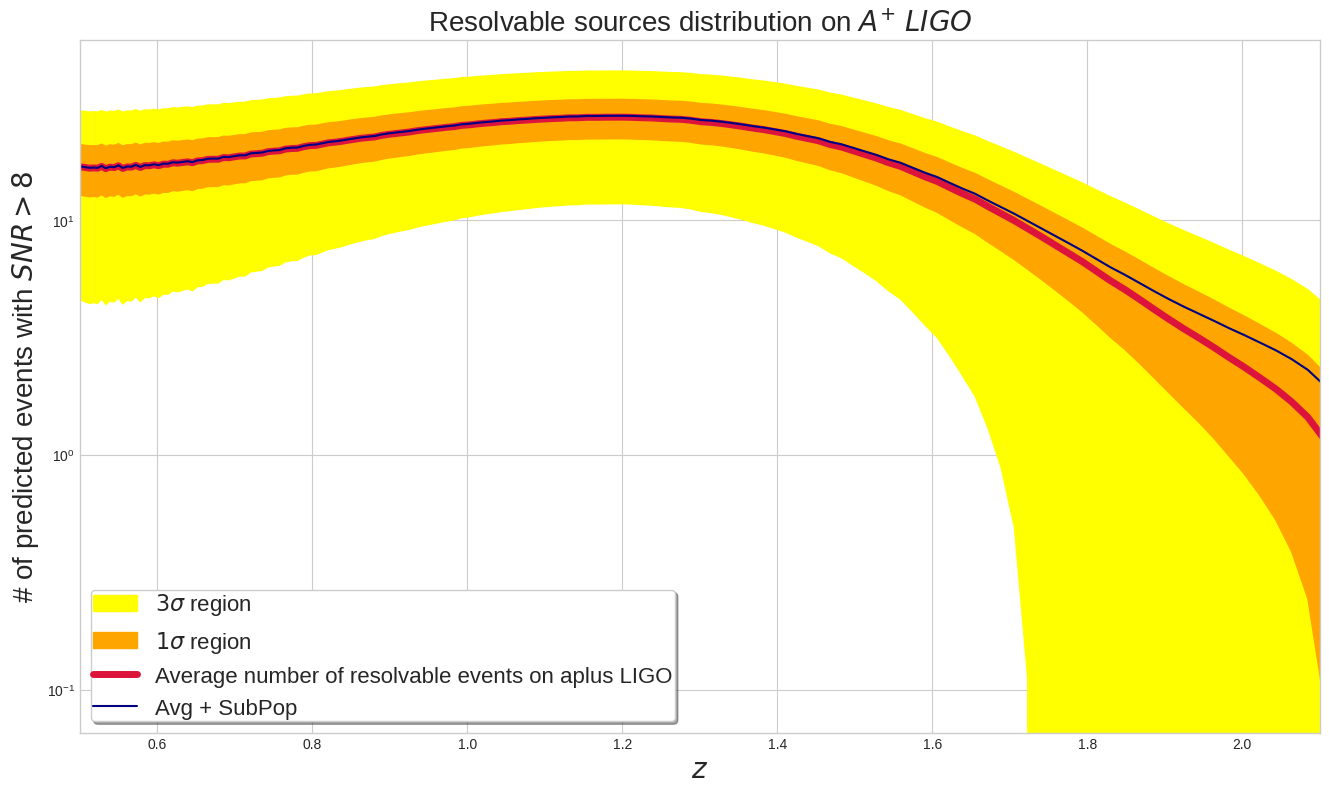

In [42]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_Res + 3.*np.sqrt(LIGO_Zdis.Fid_Res), LIGO_Zdis.Fid_Res - 3.*np.sqrt(LIGO_Zdis.Fid_Res), color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_Res + np.sqrt(LIGO_Zdis.Fid_Res), LIGO_Zdis.Fid_Res -np.sqrt(LIGO_Zdis.Fid_Res), color = 'orange', label = r'$1\sigma$ region')
plt.plot(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_Res, color = 'crimson', linewidth=5, label = 'Average number of resolvable events on aplus LIGO')
plt.plot(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_Res + LIGO_Zdis.Pert_Res, color = 'navy', label = 'Avg + SubPop')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 2.1)
plt.yscale('log')
plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of predicted events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on $A^{+} \; LIGO$',fontsize = 20)
plt.savefig('apLIGOSNRB8ResDist.png',dpi=500)

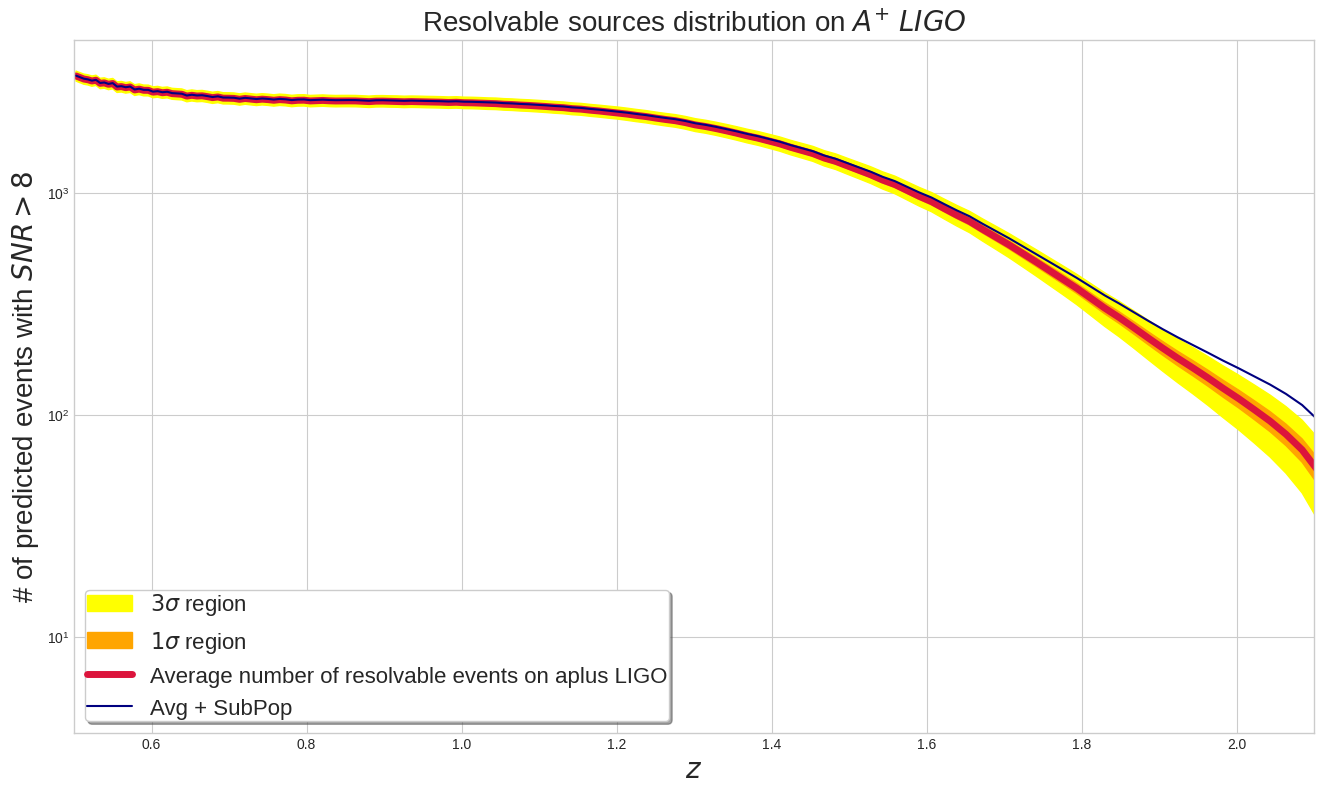

In [43]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_ResNorm + 3.*np.sqrt(LIGO_Zdis.Fid_ResNorm), LIGO_Zdis.Fid_ResNorm - 3.*np.sqrt(LIGO_Zdis.Fid_ResNorm), color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_ResNorm + np.sqrt(LIGO_Zdis.Fid_ResNorm), LIGO_Zdis.Fid_ResNorm -np.sqrt(LIGO_Zdis.Fid_ResNorm), color = 'orange', label = r'$1\sigma$ region')
plt.plot(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_ResNorm, color = 'crimson', linewidth=5, label = 'Average number of resolvable events on aplus LIGO')
plt.plot(LIGO_Zdis.Redshift, LIGO_Zdis.Fid_ResNorm + LIGO_Zdis.Pert_ResNorm, color = 'navy', label = 'Avg + SubPop')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 2.1)
plt.yscale('log')
plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of predicted events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on $A^{+} \; LIGO$',fontsize = 20)
plt.savefig('apLIGOSNRB8ResDistNormalized.png',dpi=500)

<h3> Results on ET </h3>

The results on ET will be smoothed due to loss of precision at high $z$, to do that we proceed as follows:

In [44]:
from scipy.interpolate import make_interp_spline, interp1d
#Fid_Spline = make_interp_spline(ET_Zdis.Redshift, ET_Zdis.Fid_ResNorm)
#Pert_Spline = make_interp_spline(ET_Zdis.Redshift, ET_Zdis.Pert_ResNorm)
Fid_Spline = interp1d(ET_Zdis.Redshift, ET_Zdis.Fid_ResNorm, kind = "cubic", fill_value='extrapolate')
z_plot = np.linspace(0., 10., 10000)

On the ET detector, we obtain the following distribution for the resolvable sources:

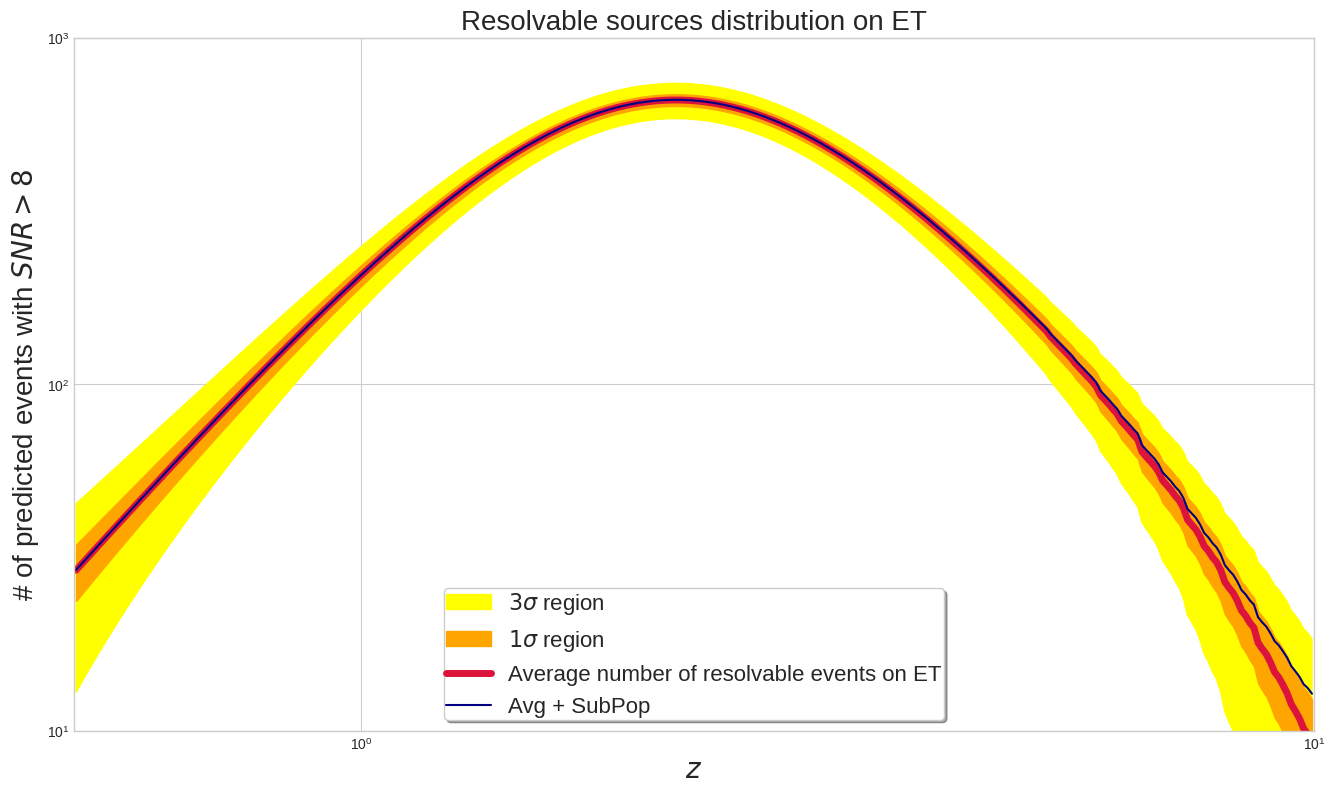

In [45]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(ET_Zdis.Redshift, ET_Zdis.Fid_Res + 3.*np.sqrt(ET_Zdis.Fid_Res), ET_Zdis.Fid_Res - 3.*np.sqrt(ET_Zdis.Fid_Res), color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(ET_Zdis.Redshift, ET_Zdis.Fid_Res + np.sqrt(ET_Zdis.Fid_Res), ET_Zdis.Fid_Res -np.sqrt(ET_Zdis.Fid_Res), color = 'orange', label = r'$1\sigma$ region')
plt.plot(ET_Zdis.Redshift, ET_Zdis.Fid_Res, color = 'crimson', linewidth=5, label = 'Average number of resolvable events on ET')
plt.plot(ET_Zdis.Redshift, ET_Zdis.Fid_Res + ET_Zdis.Pert_Res, color = 'navy', label = 'Avg + SubPop')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 10.)
plt.ylim(1.e1,1.e3)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 8, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of predicted events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on ET',fontsize = 20)
plt.savefig('ETSNRB8ResDist.png',dpi=500)

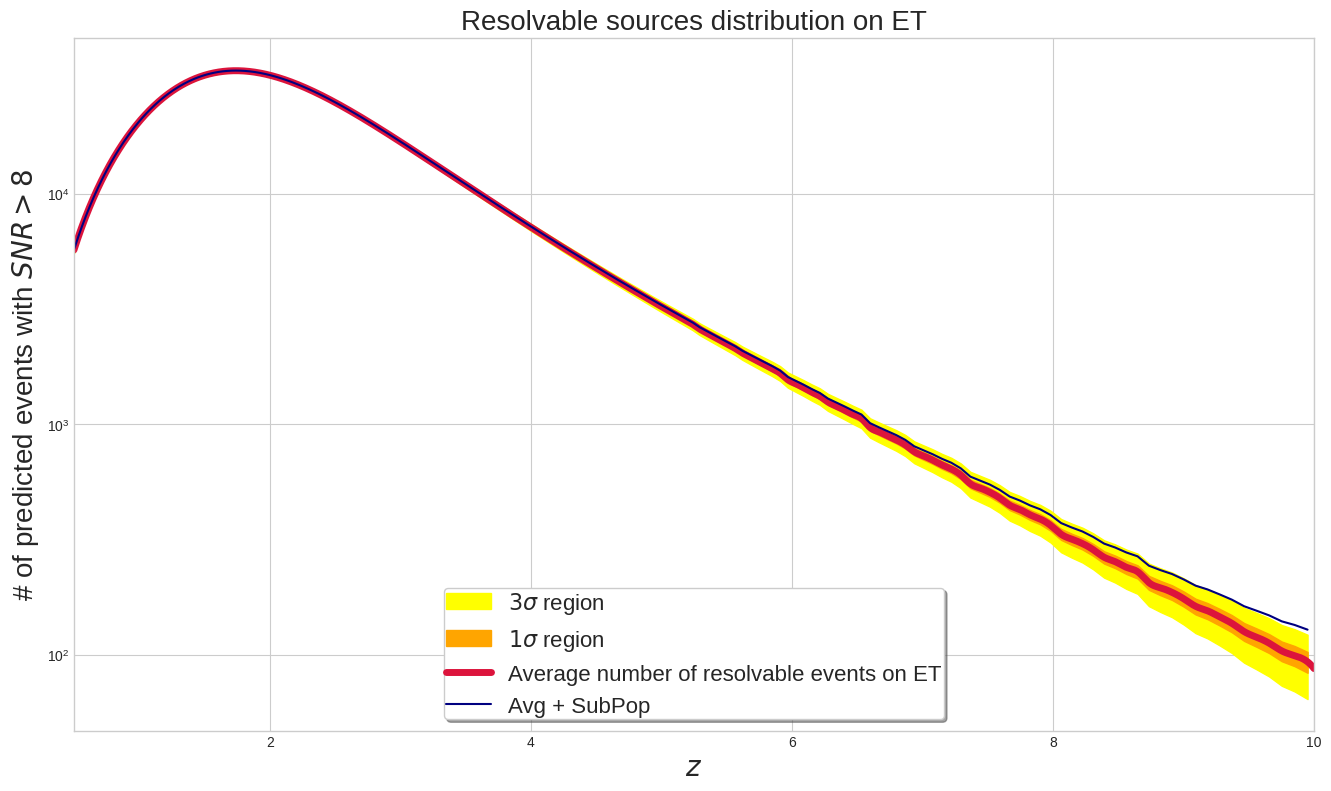

In [46]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(ET_Zdis.Redshift, ET_Zdis.Fid_ResNorm + 3.*np.sqrt(ET_Zdis.Fid_ResNorm), ET_Zdis.Fid_ResNorm - 3.*np.sqrt(ET_Zdis.Fid_ResNorm), color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(ET_Zdis.Redshift, ET_Zdis.Fid_ResNorm + np.sqrt(ET_Zdis.Fid_ResNorm), ET_Zdis.Fid_ResNorm -np.sqrt(ET_Zdis.Fid_ResNorm), color = 'orange', label = r'$1\sigma$ region')
plt.plot(z_plot, Fid_Spline(z_plot), color = 'crimson', linewidth=5, label = 'Average number of resolvable events on ET')
plt.plot(ET_Zdis.Redshift, ET_Zdis.Fid_ResNorm + ET_Zdis.Pert_ResNorm, color = 'navy', label = 'Avg + SubPop')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 10.)
#plt.ylim(1.e1,1.e3)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 8, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of predicted events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on ET',fontsize = 20)
plt.savefig('ETSNRB8ResDistNormalized.png',dpi=500)

<h2> Saving the dataset </h2>

In [47]:
LIGO_Zdis.to_hdf('LIGOResDistPoint8.h5', 'LIGO', mode='w') 
ET_Zdis.to_hdf('ETResDistPoint8.h5', 'ET', mode='w') 

<h3> Setting alarm to inform when simulation is over </h3>

In [48]:
#file = 'Alarm-ringtone.mp3'
#os.system("mpg123 "+file)